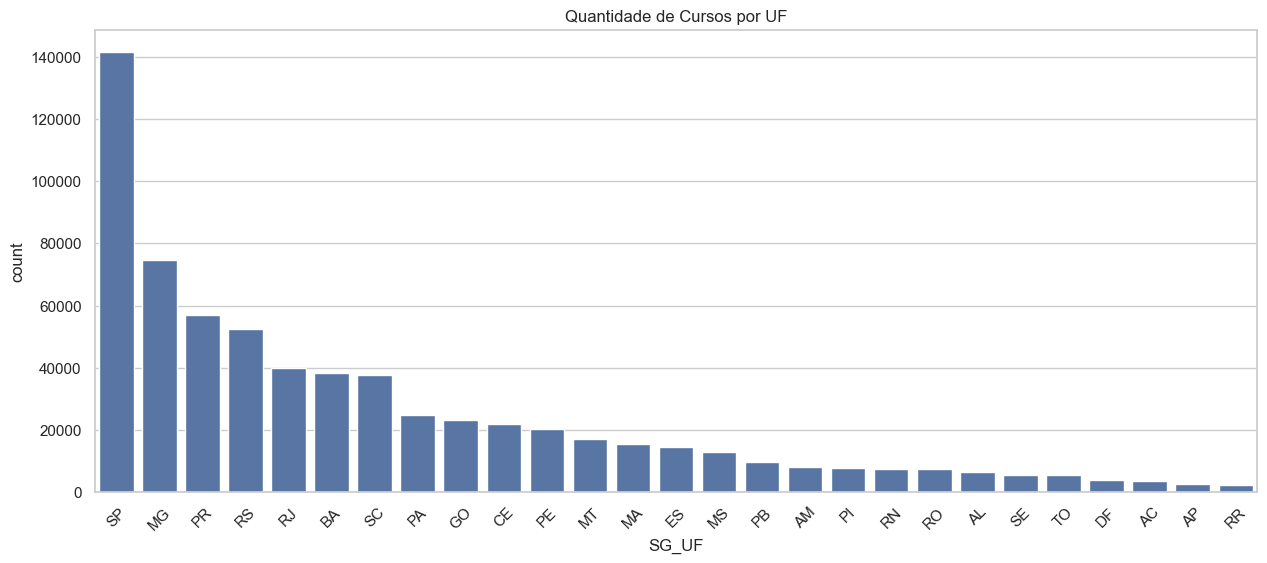

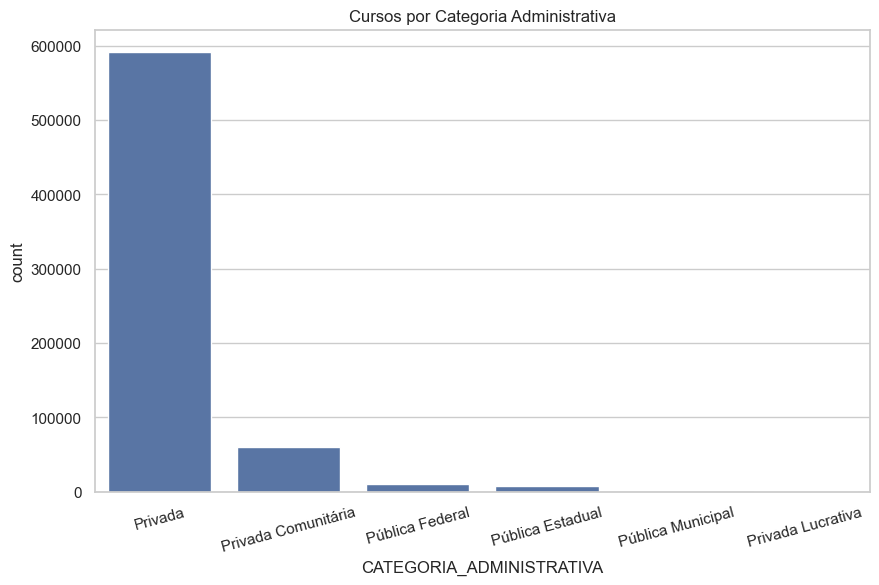

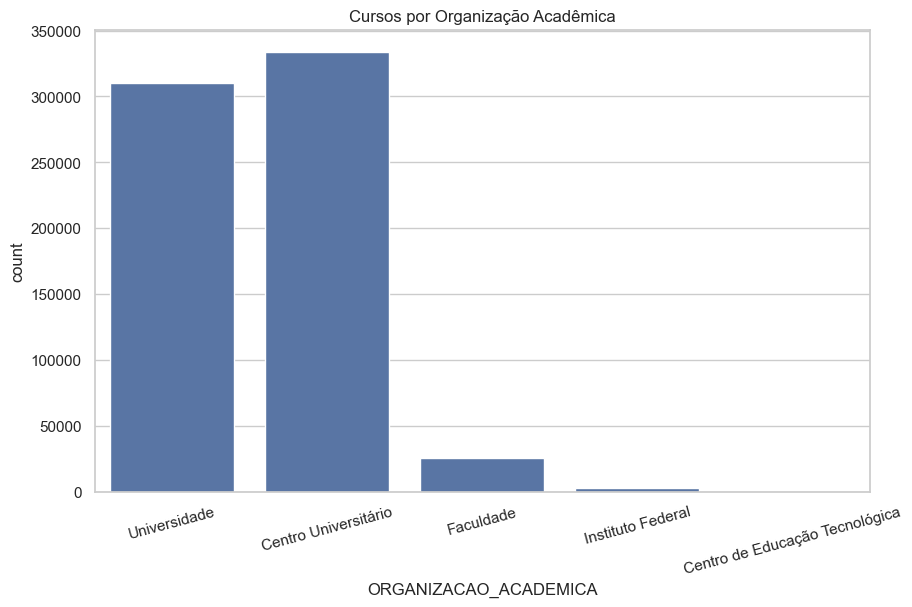

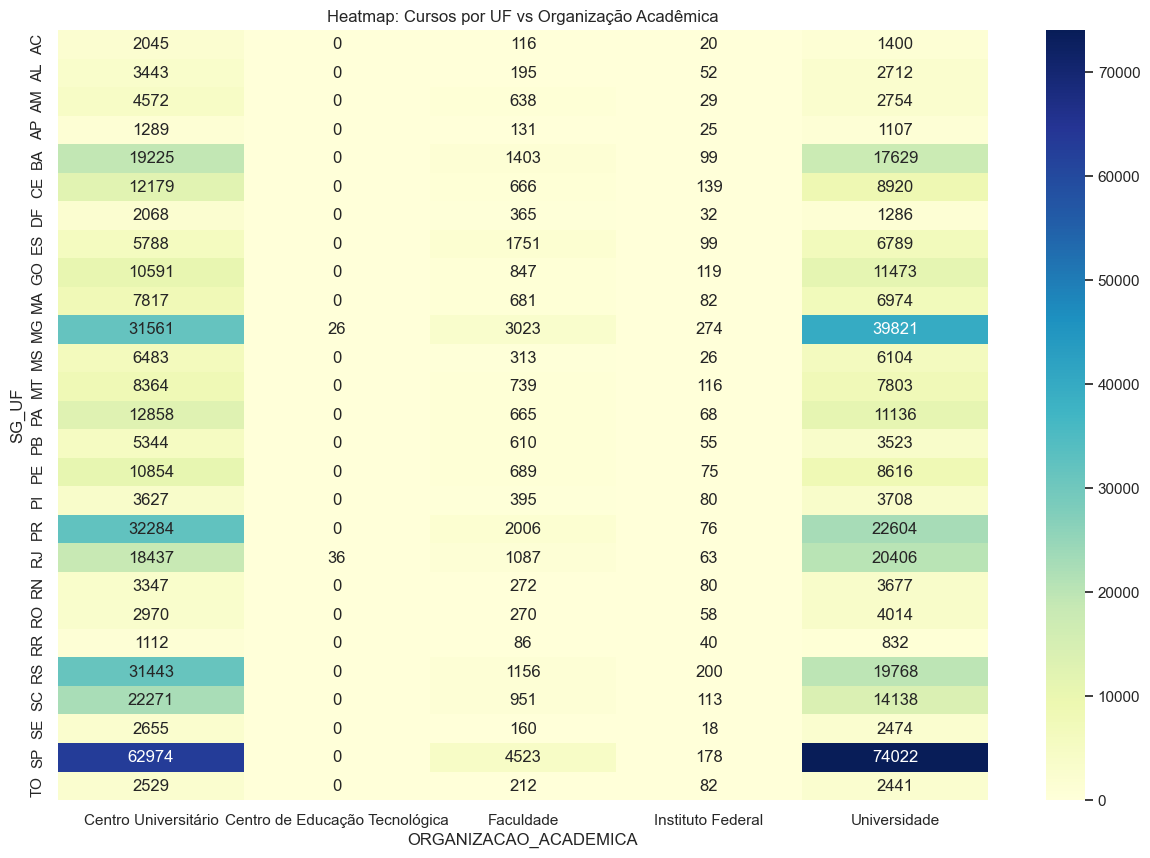

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sys

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

sys.path.append('..')

base_path = '../data/'

from scripts.limpeza import carregar_e_filtrar

df_cursos, df_ies = carregar_e_filtrar(base_path)

df_cursos.head()

plt.figure(figsize=(15, 6))
sns.countplot(data=df_cursos, x='SG_UF', order=df_cursos['SG_UF'].value_counts().index)
plt.title('Quantidade de Cursos por UF')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df_cursos, x='CATEGORIA_ADMINISTRATIVA')
plt.title('Cursos por Categoria Administrativa')
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df_cursos, x='ORGANIZACAO_ACADEMICA')
plt.title('Cursos por Organização Acadêmica')
plt.xticks(rotation=15)
plt.show()

pivot = df_cursos.pivot_table(
    index='SG_UF',
    columns='ORGANIZACAO_ACADEMICA',
    values='NO_CURSO',
    aggfunc='count',
    fill_value=0
)
plt.figure(figsize=(15, 10))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap: Cursos por UF vs Organização Acadêmica')
plt.show()

uf_counts = df_cursos['SG_UF'].value_counts().reset_index()
uf_counts.columns = ['UF', 'Quantidade']

fig = px.bar(
    uf_counts,
    x='UF',
    y='Quantidade',
    title='Quantidade de Cursos por UF (Interativo)',
    text_auto=True,
    color='UF'
)
fig.show()

file_cnpq = base_path + 'Relatorio_de_dados_abertos_CNPq (1º SEM 2023)(snICJ).xlsx'
df_cnpq = pd.read_excel(file_cnpq, skiprows=5, header=0)

df_cnpq_grouped = df_cnpq.groupby('Sigla UF Destino').size().reset_index(name='Bolsistas')

cursos_por_uf = df_cursos['SG_UF'].value_counts().reset_index()
cursos_por_uf.columns = ['UF', 'Cursos']

df_merged = pd.merge(cursos_por_uf, df_cnpq_grouped, left_on='UF', right_on='Sigla UF Destino', how='inner')

fig_scatter = px.scatter(
    df_merged,
    x='Cursos',
    y='Bolsistas',
    text='UF',
    title='Relação entre Número de Cursos e Bolsistas CNPq por UF',
    trendline='ols'
)
fig_scatter.show()
